In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
from tensorflow.keras import layers, models
from tensorflow.python.ops.gen_batch_ops import batch
print('Done')

Done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [ ]:
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Code basics/Tomato leaf',
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    shuffle = True,
    batch_size = BATCH_SIZE
)

Found 9747 files belonging to 10 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__YellowLeaf__Curl_Virus',
 'Tomato___mosaic_virus',
 'Tomato_healthy']

In [ ]:
len(dataset)

305

In [ ]:
# actual length
305*32   # len of the dataset * batch size

9760

In [ ]:
# shape of the first image
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape, class_names[label_batch[0]])

(256, 256, 3) Tomato_Septoria_leaf_spot


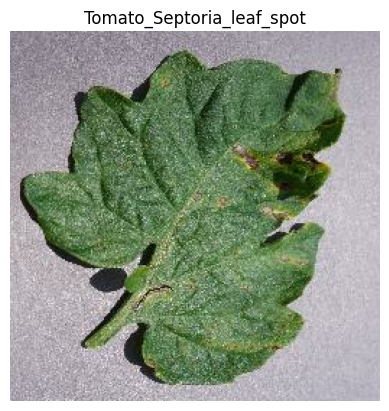

In [ ]:
# first image
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])
    plt.axis('off')

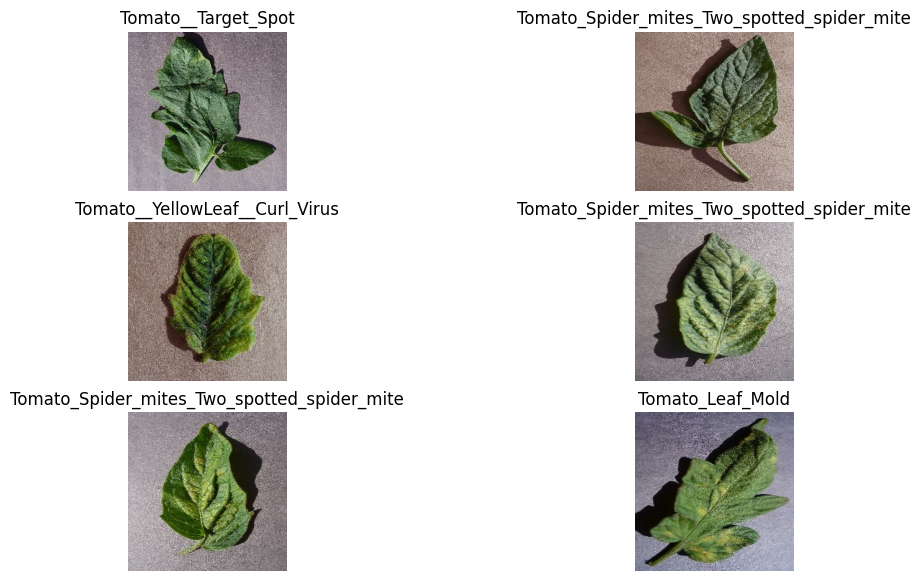

In [ ]:
plt.figure(figsize = (12,7))

for image_batch, label_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3,2, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [ ]:
# 80% training
# 10% validation
# 10% testing

In [ ]:
# function to split the dataset

def get_dataset_partitions(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1 , shuffle = True, shuffle_size = 10000 ):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [ ]:
print(len(train_ds), len(val_ds), len(test_ds))

244 30 31


## Preprocessing

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
# resizing and rescaling

resize_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.3)
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(48, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

# Building the Model

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
164/164 [==============================] - 555s 563ms/step - loss: 1.5887 - accuracy: 0.3801 - val_loss: 1.3842 - val_accuracy: 0.4516
Epoch 2/10
164/164 [==============================] - 10s 60ms/step - loss: 1.3044 - accuracy: 0.4943 - val_loss: 1.1969 - val_accuracy: 0.5344
Epoch 3/10
164/164 [==============================] - 10s 61ms/step - loss: 1.1149 - accuracy: 0.5755 - val_loss: 1.3759 - val_accuracy: 0.5250
Epoch 4/10
164/164 [==============================] - 10s 58ms/step - loss: 0.9949 - accuracy: 0.6206 - val_loss: 1.0426 - val_accuracy: 0.6156
Epoch 5/10
164/164 [==============================] - 10s 59ms/step - loss: 0.8241 - accuracy: 0.6919 - val_loss: 0.8889 - val_accuracy: 0.6969
Epoch 6/10
164/164 [==============================] - 10s 60ms/step - loss: 0.7009 - accuracy: 0.7349 - val_loss: 0.6872 - val_accuracy: 0.7469
Epoch 7/10
164/164 [==============================] - 10s 61ms/step - loss: 0.6099 - accuracy: 0.7736 - val_loss: 0.6270 - val_accurac

Val accuracy is very low so increasing few more epochs.

In [ ]:
history = model.fit(
    train_ds,
    epochs = 25,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25
164/164 [==============================] - 10s 59ms/step - loss: 0.4017 - accuracy: 0.8527 - val_loss: 0.5207 - val_accuracy: 0.8031
Epoch 2/25
164/164 [==============================] - 10s 59ms/step - loss: 0.3616 - accuracy: 0.8660 - val_loss: 0.4791 - val_accuracy: 0.8281
Epoch 3/25
164/164 [==============================] - 10s 60ms/step - loss: 0.3473 - accuracy: 0.8721 - val_loss: 0.5000 - val_accuracy: 0.8219
Epoch 4/25
164/164 [==============================] - 10s 60ms/step - loss: 0.2880 - accuracy: 0.8965 - val_loss: 0.5724 - val_accuracy: 0.8094
Epoch 5/25
164/164 [==============================] - 10s 59ms/step - loss: 0.2814 - accuracy: 0.8941 - val_loss: 0.6925 - val_accuracy: 0.7953
Epoch 6/25
164/164 [==============================] - 10s 60ms/step - loss: 0.2692 - accuracy: 0.9038 - val_loss: 0.3900 - val_accuracy: 0.8687
Epoch 7/25
164/164 [==============================] - 10s 60ms/step - loss: 0.2559 - accuracy: 0.9103 - val_loss: 0.3895 - val_accuracy:

In [ ]:
scores = model.evaluate(test_ds)

111/111 [==============================] - 340s 31ms/step - loss: 0.2966 - accuracy: 0.9053


In [ ]:
scores

[0.29658791422843933, 0.9053404927253723]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

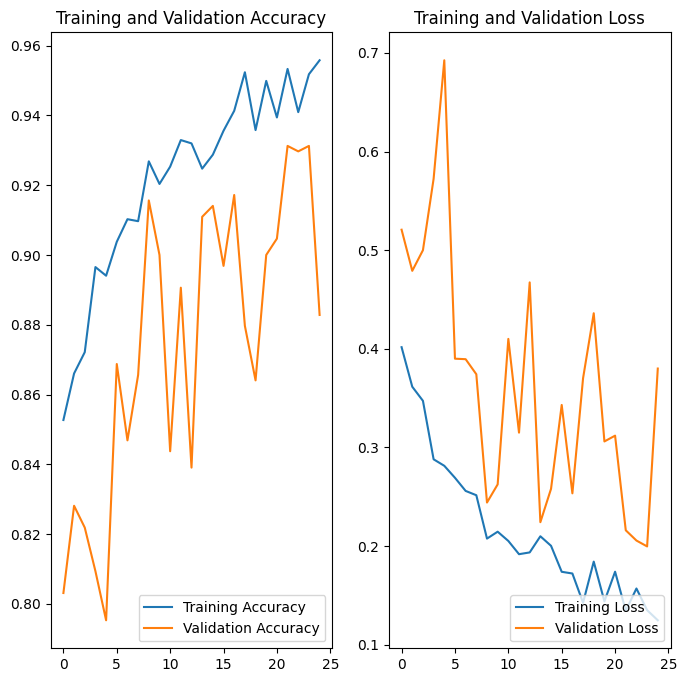

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(25), acc, label = 'Training Accuracy')
plt.plot(range(25), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(25), loss, label = 'Training Loss')
plt.plot(range(25), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# function to predict the images

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


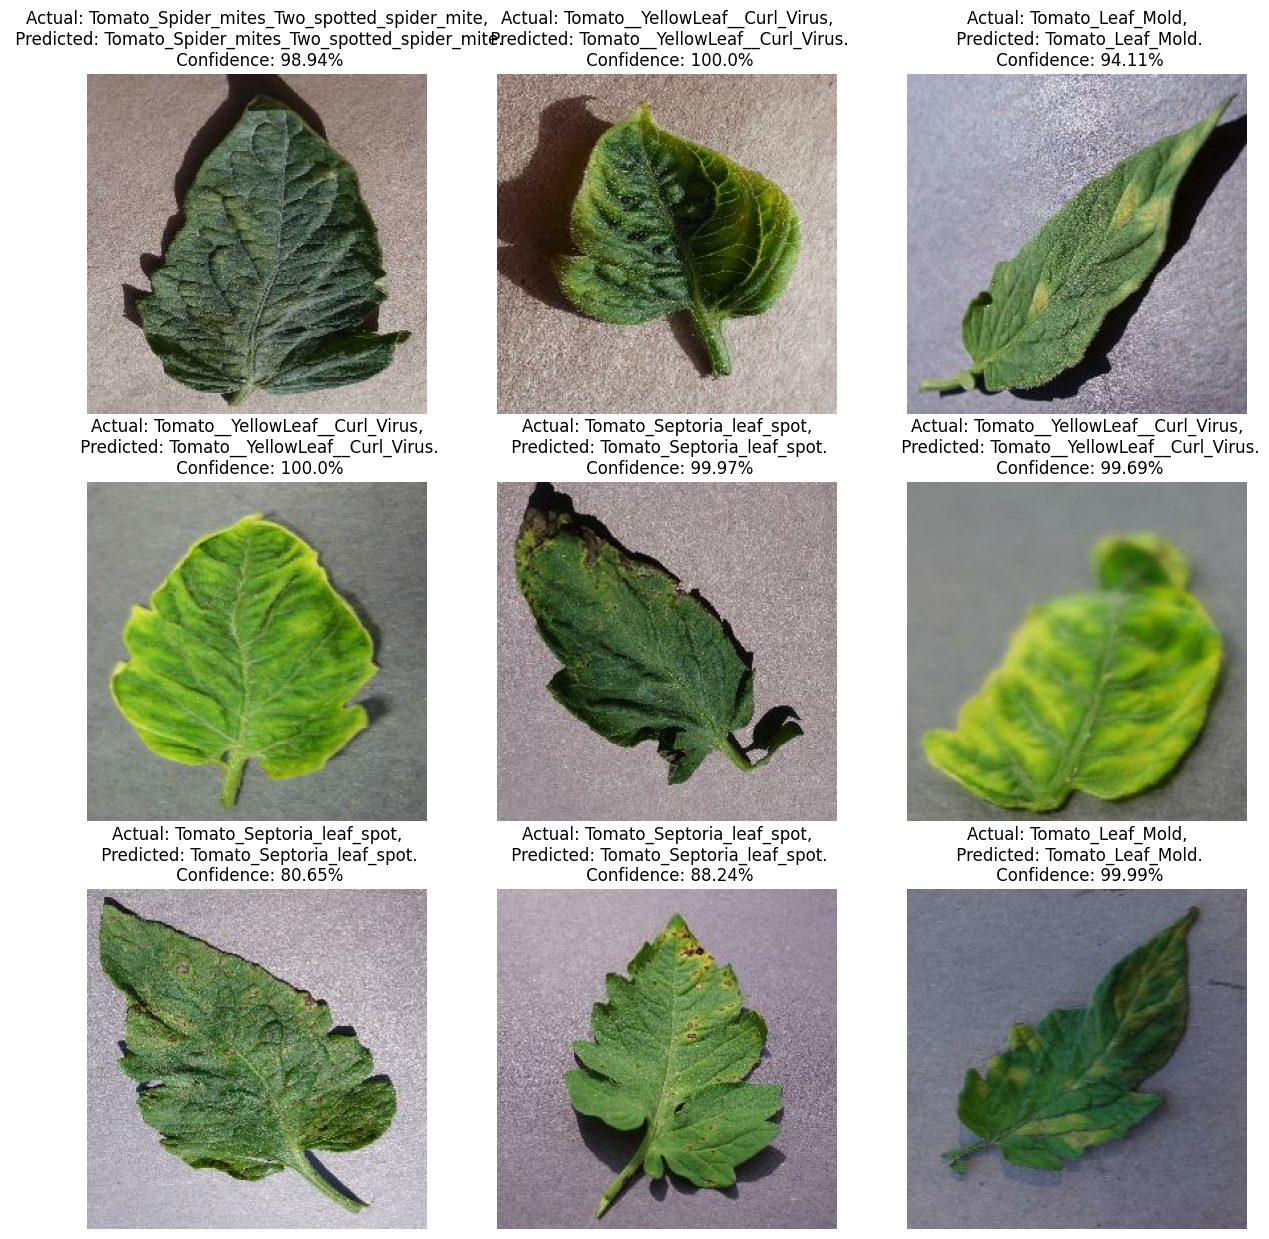

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%", fontsize = 12)

        plt.axis("off")